In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import ImageEnhance
from tqdm import tqdm, trange
import os, sys
import rawpy
import zivid
import yaml

In [2]:
path = "data"
zdf1 = "20221117_1013_calib_test.zdf"
cam2 = "DSCF9210.RAF" 
width, height = 11, 8
square_size = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [3]:
def generate_masked_image(image, p1, p2, preview=None):
    # generate a mask
    mask = np.zeros(image.shape, dtype=np.uint8)
    mask = cv2.rectangle(mask, p1, p2, (255, 255, 255), -1)
    # masked_image = cv2.bitwise_and(image, mask)
    if preview is not None:
        mask_preview = cv2.rectangle(np.zeros(image.shape, dtype=np.uint8), p1, p2, (255, 0, 0), -1)
        mask_preview = cv2.addWeighted(image, 0.8, mask_preview, 0.2, 0)
        mask_preview = cv2.cvtColor(mask_preview, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(path, "ref", preview+".jpg"), mask_preview)
    # return masked_image

current_pos = None
tl = None
br = None

def get_rect(im, title='get_rect'): # (a,b) = get_rect(im, title='get_rect')
    mouse_params = {'tl': None, 'br': None, 'current_pos': None, 'released_once': False}

    ratio = 1000 / im.shape[0]
    im = cv2.resize(im, (0, 0), fx=ratio, fy=ratio)

    cv2.namedWindow(title)
    cv2.moveWindow(title, 1500, 200)

    def onMouse(event, x, y, flags, param):

        param['current_pos'] = (x, y)

        if param['tl'] is not None and not (flags & cv2.EVENT_FLAG_LBUTTON):
            param['released_once'] = True

        if flags & cv2.EVENT_FLAG_LBUTTON:
            if param['tl'] is None:
                param['tl'] = param['current_pos']
            elif param['released_once']:
                param['br'] = param['current_pos']

    cv2.setMouseCallback(title, onMouse, mouse_params)
    cv2.imshow(title, im)

    while mouse_params['br'] is None:
        im_draw = np.copy(im)

        if mouse_params['tl'] is not None:
            cv2.rectangle(im_draw, mouse_params['tl'],
                mouse_params['current_pos'], (255, 0, 0))

        cv2.imshow(title, im_draw)
        _ = cv2.waitKey(10)

    cv2.destroyWindow(title)

    tl = (min(mouse_params['tl'][0], mouse_params['br'][0]),
        min(mouse_params['tl'][1], mouse_params['br'][1]))
    br = (max(mouse_params['tl'][0], mouse_params['br'][0]),
        max(mouse_params['tl'][1], mouse_params['br'][1]))

    tl = (int(tl[0] / ratio), int(tl[1] / ratio))
    br = (int(br[0] / ratio), int(br[1] / ratio))

    return (tl, br)

# get_rect(np.zeros((1000,1000,3), dtype=np.uint8), title='get_rect')

In [4]:
# load zivid zdf file
app = zivid.Application()
frame = zivid.Frame(os.path.join(path, zdf1))
# get rgb image
rgb = frame.point_cloud().copy_data("rgba")[:,:,:3]
print(rgb.shape)

(1200, 1920, 3)


105 20 1558 1138 1118 1453


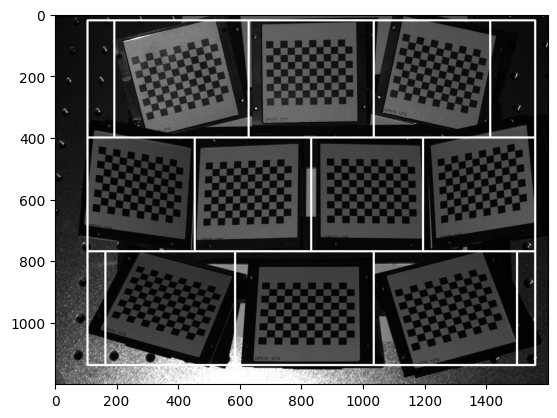

In [5]:
img1 = rgb[::-1, ::-1, :]
img1 = img1[:, 160:-160, :]
gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

tl, br = get_rect(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR), title='get_rect')

x1, y1, x2, y2 = 40, 20, 1550, 1170
x1, y1, x2, y2 = tl[0], tl[1], br[0], br[1]
h, w = y2-y1, x2-x1
print(x1, y1, x2, y2, h, w)

cv2.rectangle(gray, (x1, y1), (x2, y2), (255, 0, 0), 5)

h0, h1, h2, h3 = 0, 0.34, 0.67, 1
w0, w1, w2, w3 = 0.06, 0.36, 0.64, 0.90
w4, w5, w6 = 0.24, 0.5, 0.75
w7, w8, w9, w10 = 0.04, 0.33, 0.64, 0.96

cam1_p1 = [
    [[y1+h0*h, x1+w0*w], [y1+h1*h, x1+w1*w]],
    [[y1+h0*h, x1+w1*w], [y1+h1*h, x1+w2*w]],
    [[y1+h0*h, x1+w2*w], [y1+h1*h, x1+w3*w]],

    [[y1+h1*h, x1], [y1+h2*h, x1+w4*w]],
    [[y1+h1*h, x1+w4*w], [y1+h2*h, x1+w5*w]],
    [[y1+h1*h, x1+w5*w], [y1+h2*h, x1+w6*w]],
    [[y1+h1*h, x1+w6*w], [y1+h2*h, x1+w]],

    [[y1+h2*h, x1+w7*w], [y1+h3*h, x1+w8*w]],
    [[y1+h2*h, x1+w8*w], [y1+h3*h, x1+w9*w]],
    [[y1+h2*h, x1+w9*w], [y1+h3*h, x1+w10*w]],
]

cam1_p1 = np.asarray(cam1_p1, dtype=np.int32)
cam1_p1 = cam1_p1[:, :, ::-1]
for b in cam1_p1:
    cv2.rectangle(gray, b[0], b[1], (255, 0, 0), 5)
plt.imshow(gray, cmap="gray")

3135 1921 7789 5527 3606 4654


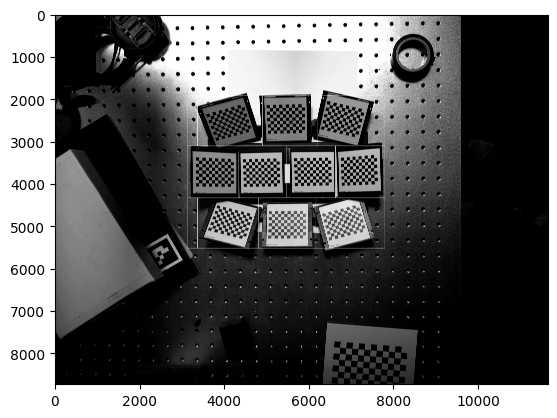

In [6]:
img2 = rawpy.imread(os.path.join(path, cam2)).postprocess(use_camera_wb=True, no_auto_bright=True, output_bps=8)[:8733, :11644]
# increase img contrast
img2 = Image.fromarray(img2)
img2 = ImageEnhance.Contrast(img2).enhance(2)
img2 = np.asarray(img2)
gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

tl, br = get_rect(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), title='get_rect')

x1, y1, x2, y2 = 3000, 2000, 7600, 5700
x1, y1, x2, y2 = tl[0], tl[1], br[0], br[1]

h, w = y2-y1, x2-x1
print(x1, y1, x2, y2, h, w)

cv2.rectangle(gray, (x1, y1), (x2, y2), (255, 0, 0), 5)

h0, h1, h2, h3 = 0, 0.33, 0.67, 1
w0, w1, w2, w3 = 0.05, 0.38, 0.66, 0.95
w4, w5, w6 = 0.25, 0.5, 0.75
w7, w8, w9, w10 = 0.05, 0.36, 0.65, 0.93

cam2_p1 = [
    [[y1+h0*h, x1+w0*w], [y1+h1*h, x1+w1*w]],
    [[y1+h0*h, x1+w1*w], [y1+h1*h, x1+w2*w]],
    [[y1+h0*h, x1+w2*w], [y1+h1*h, x1+w3*w]],

    [[y1+h1*h, x1], [y1+h2*h, x1+w4*w]],
    [[y1+h1*h, x1+w4*w], [y1+h2*h, x1+w5*w]],
    [[y1+h1*h, x1+w5*w], [y1+h2*h, x1+w6*w]],
    [[y1+h1*h, x1+w6*w], [y1+h2*h, x1+w]],

    [[y1+h2*h, x1+w7*w], [y1+h3*h, x1+w8*w]],
    [[y1+h2*h, x1+w8*w], [y1+h3*h, x1+w9*w]],
    [[y1+h2*h, x1+w9*w], [y1+h3*h, x1+w10*w]],
]

cam2_p1 = np.asarray(cam2_p1, dtype=np.int32)
cam2_p1 = cam2_p1[:, :, ::-1]

for b in cam2_p1:
    cv2.rectangle(gray, b[0], b[1], (255, 0, 0), 5)
plt.imshow(gray, cmap="gray")

In [7]:
print(img1.shape, img2.shape)
os.makedirs(os.path.join(path, "ref"), exist_ok=True)
for i in trange(len(cam1_p1)):
    p1, p2 = cam1_p1[i]
    generate_masked_image(img1, p1, p2, f"cam1_{i}")
    p1, p2 = cam2_p1[i]
    generate_masked_image(img2, p1, p2, f"cam2_{i}")

(1200, 1600, 3) (8733, 11644, 3)


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


In [8]:
ratio = 8733/1200
print(ratio)
# img1 = cv2.resize(img1, (0, 0), fx=ratio, fy=ratio)
# cam1_p1 = (cam1_p1 * ratio).astype(np.int32)
# print(img1.shape, img2.shape)

7.2775


In [9]:
os.makedirs(os.path.join(path, "ref", "cb"), exist_ok=True)

objp = np.zeros((height*width, 3), np.float32)
objp[:, :2] = np.mgrid[0:width*square_size:square_size, 0:height*square_size:square_size].T.reshape(-1, 2)

objpoints1 = [] # 3d point in real world space
imgpoints1 = [] # 2d points in image plane

preview = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
preview = cv2.resize(preview, (0, 0), fx=ratio, fy=ratio)
for i in trange(10):
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    p1, p2 = cam1_p1[i]
    sub_gray = gray[p1[1]:p2[1], p1[0]:p2[0]]
    ret, corners = cv2.findChessboardCorners(sub_gray, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret:
        objpoints1.append(objp)
        corners2 = cv2.cornerSubPix(sub_gray, corners, (11, 11), (-1, -1), criteria)
        corners2 += np.array(p1)
        corners2 = corners2 * ratio
        imgpoints1.append(corners2)

        cv2.drawChessboardCorners(preview, (width, height), corners2, ret)
    else:
        print("not found")

cv2.imwrite(os.path.join(path, "ref", "cb", f"single1.jpg"), preview)

ret1, mtx1, dist1, _, _ = cv2.calibrateCamera(objpoints1, imgpoints1, (11644, 8733), None, None)

print("ret", ret1)
print("mtx", mtx1)
print("dist", dist1)

100%|██████████| 10/10 [00:00<00:00, 69.93it/s]


ret 0.6325785021678314
mtx [[1.99086605e+04 0.00000000e+00 5.84917531e+03]
 [0.00000000e+00 1.99161835e+04 4.43551216e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist [[-2.73553112e-01  1.06205615e-01  3.42445957e-04 -5.68729437e-04
   1.75692568e+00]]


In [10]:
objp = np.zeros((height*width, 3), np.float32)
objp[:, :2] = np.mgrid[0:width*square_size:square_size, 0:height*square_size:square_size].T.reshape(-1, 2)

objpoints2 = [] # 3d point in real world space
imgpoints2 = [] # 2d points in image plane

preview = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

for i in trange(10):
    gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    p1, p2 = cam2_p1[i]
    sub_gray = gray[p1[1]:p2[1], p1[0]:p2[0]]
    ret, corners = cv2.findChessboardCorners(sub_gray, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret:
        objpoints2.append(objp)
        corners2 = cv2.cornerSubPix(sub_gray, corners, (11, 11), (-1, -1), criteria)
        corners2 += np.array(p1)
        imgpoints2.append(corners2)

        cv2.drawChessboardCorners(preview, (width, height), corners2, ret)
    else:
        print("not found")

cv2.imwrite(os.path.join(path, "ref", "cb", f"single2.jpg"), preview)

ret2, mtx2, dist2, _, _ = cv2.calibrateCamera(objpoints2, imgpoints2, (11644, 8733), None, None)

print("ret", ret2)
print("mtx", mtx2)
print("dist", dist2)

100%|██████████| 10/10 [00:00<00:00, 12.98it/s]


ret 0.12133144800325983
mtx [[8.37157906e+03 0.00000000e+00 5.82076898e+03]
 [0.00000000e+00 8.36783655e+03 4.35310469e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist [[-3.93513885e-03 -1.06349611e-01 -5.06432270e-04 -8.02066491e-05
   4.24281698e-01]]


In [11]:
if len(imgpoints1) != 10 or len(imgpoints2) != 10:
    raise ValueError("not enough images")

In [12]:
retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(objpoints2, imgpoints2, imgpoints1, mtx2, dist2, mtx1, dist1, (11644, 8733), flags=cv2.CALIB_FIX_INTRINSIC+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5)

print("retval", retval)
print("cameraMatrix1", cameraMatrix1)
print("distCoeffs1", distCoeffs1)
print("cameraMatrix2", cameraMatrix2)
print("distCoeffs2", distCoeffs2)
print("R", R)
print("T", T)
print("E", E)   
print("F", F)

# export to yaml
data = {
    "cameraMatrix1": cameraMatrix1.tolist(),
    "distCoeffs1": distCoeffs1.tolist(),
    "cameraMatrix2": cameraMatrix2.tolist(),
    "distCoeffs2": distCoeffs2.tolist(),
    "R": R.tolist(),
    "T": T.tolist(),
    "E": E.tolist(),
    "F": F.tolist(),
}

with open(os.path.join(path, "calib_result.yaml"), "w") as f:
    yaml.dump(data, f)
    

retval 0.5079253710946254
cameraMatrix1 [[8.37157906e+03 0.00000000e+00 5.82076898e+03]
 [0.00000000e+00 8.36783655e+03 4.35310469e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distCoeffs1 [[-3.93513885e-03 -1.06349611e-01 -5.06432270e-04 -8.02066491e-05
   4.24281698e-01]]
cameraMatrix2 [[1.99086605e+04 0.00000000e+00 5.84917531e+03]
 [0.00000000e+00 1.99161835e+04 4.43551216e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distCoeffs2 [[-2.73553112e-01  1.06205615e-01  3.42445957e-04 -5.68729437e-04
   1.75692568e+00]]
R [[ 0.99926021 -0.02253171  0.03116671]
 [ 0.01194207  0.95213255  0.30545211]
 [-0.0365572  -0.30485394  0.95169724]]
T [[   8.68263766]
 [-141.69100923]
 [   6.51946393]]
E [[   5.10197036   36.98766871 -136.83832712]
 [   6.83205377    2.50004162   -8.0600521 ]
 [ 141.68987569    5.07448086    7.06817254]]
F [[-6.94971075e-10 -5.04057350e-09  1.82030283e-04]
 [-9.30284949e-10 -3.40569814e-10  1.60852764e-05]
 [-3.76054969e-04  1.72262500e-05  1.0000000